<a href="https://colab.research.google.com/github/ziatdinovmax/atomai/blob/master/examples/notebooks/Cards_jrVAE_v2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installations:

In [ ]:
!pip install atomai
!pip install git+https://github.com/kornia/kornia.git # install from the master branch until the next stable release (see https://github.com/kornia/kornia/issues/902) 

  Cloning https://github.com/ziatdinovmax/atomai (to revision maxdev) to /tmp/pip-req-build-c5hgrzl9
  Running command git clone -q https://github.com/ziatdinovmax/atomai /tmp/pip-req-build-c5hgrzl9
  Running command git checkout -b maxdev --track origin/maxdev
  Switched to a new branch 'maxdev'
  Branch 'maxdev' set up to track remote branch 'maxdev' from 'origin'.
     |████████████████████████████████| 194kB 12.9MB/s 
     |████████████████████████████████| 870kB 22.4MB/s 
  Created wheel for atomai: filename=atomai-0.6.5-cp37-none-any.whl size=123558 sha256=7f48d5a85469cce3d05baf9eb4c8d4c521da7b3e28db599c3d1e9245dc301f4a
  Stored in directory: /tmp/pip-ephem-wheel-cache-o_t30rbx/wheels/bb/c7/8c/0efd34c28b875a0e451edabea2abdcbf8227c4966f6e17bd9d
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174964 sha256=d8a16dc2f87d4a894a65c5db2166736bb64e9a5967679b404f9e6ce0de6fc1f4
  Stored in directory: /root/.cache/pip/wheels/fb/28/5d/95e69a718b35dd00169889b

Download data:

In [ ]:
!gdown https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
!unzip cards.zip

Downloading...
From: https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
To: /content/cards.zip
100% 30.2k/30.2k [00:00<00:00, 51.9MB/s]
Archive:  cards.zip
   creating: cards/
  inflating: cards/card4.JPG         
  inflating: cards/card1.JPG         
  inflating: cards/card2.JPG         
  inflating: cards/card3.JPG         


Imports:

In [ ]:
import atomai_app as aoi
import kornia as K
import cv2
import torch
import torch.nn as nn
import torch.tensor as tt
import numpy as np
import matplotlib.pyplot as plt

Load data into the notebook and transform to a proper format:

In [ ]:
card1 = cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE)
card2 = cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE)
card3 = cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE)
card4 = cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE)

card1 = tt(1 - card1 / card1.max())
card2 = tt(1 - card2 / card2.max())
card3 = tt(1 - card3 / card3.max())
card4 = tt(1 - card4 / card4.max())

Define a helper function for data augmentation:

In [ ]:
def transform_images(*args, **kwargs):
    torch.manual_seed(0)
    card1, card2, card3, card4 = args
    a = kwargs.get("angle", 60)
    t = kwargs.get("translation", 0.1)
    s = kwargs.get("shear", 5)
    # Define transform(s)
    transform = nn.Sequential(
        K.Resize((64, 64)),
        K.augmentation.CenterCrop((48, 48)),
        K.augmentation.RandomAffine(a, translate=t, shear=[-s, s, -s, s], p=1)
    )
    # Apply random transformations to a batch of 3000 images for each card type
    cards1 = transform(card1[None, None].repeat_interleave(3000, dim=0))
    cards2 = transform(card2[None, None].repeat_interleave(3000, dim=0))
    cards3 = transform(card3[None, None].repeat_interleave(3000, dim=0))
    cards4 = transform(card4[None, None].repeat_interleave(3000, dim=0))

    # Concatenate (this is our training set)
    cards_all = torch.cat([cards1, cards2, cards3, cards4]).squeeze().float()
    labels_all = torch.cat([torch.zeros(len(cards1)), torch.ones(len(cards2)),
                           2*torch.ones(len(cards3)), 3*torch.ones(len(cards4))])
    return cards_all, labels_all

# We are going to augment data with a specific set of parameters before each run, so this is just an example
cards_all, labels_all = transform_images(card1, card2, card3, card4, angle=60)

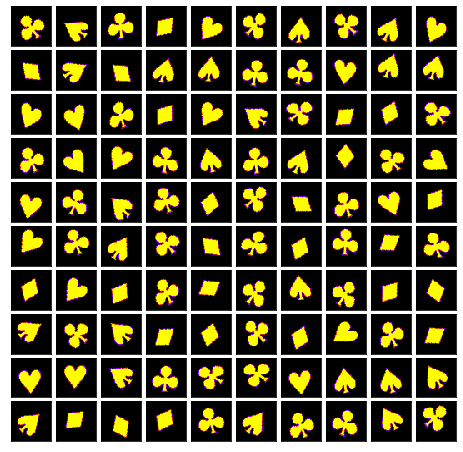

In [ ]:
np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all))
    ax.imshow(cards_all[i], cmap='gnuplot', interpolation='nearest')

##VAE

Train  a standard VAE model for four types of disorder:

In [ ]:
input_dim = (48, 48)

aug_params = {1: [12, 0.1, 1], 2: [12, 0.1, 10], 3: [120, 0.1, 1], 4: [120, 0.1, 10]}

for p in aug_params.values():

    cards_all, _ = transform_images(
        card1, card2, card3, card4, angle=p[0], translation=p[1], shear=p[2])
    
    vae = aoi.models.VAE(input_dim, latent_dim=2,
                         numlayers_encoder=3, numhidden_encoder=512,
                         numlayers_decoder=3, numhidden_decoder=512,
                         skip=True)
    
    vae.fit(cards_all, training_cycles=200, batch_size=100, loss="ce", translation_prior=0.1,
             filename="/content/drive/MyDrive/research/joint_rVAE/VAE_cards_degree{}shear{}".format(p[0], p[2]))

Load the trained VAE models and plot the learned manifolds and data encodings:

Latent manifold


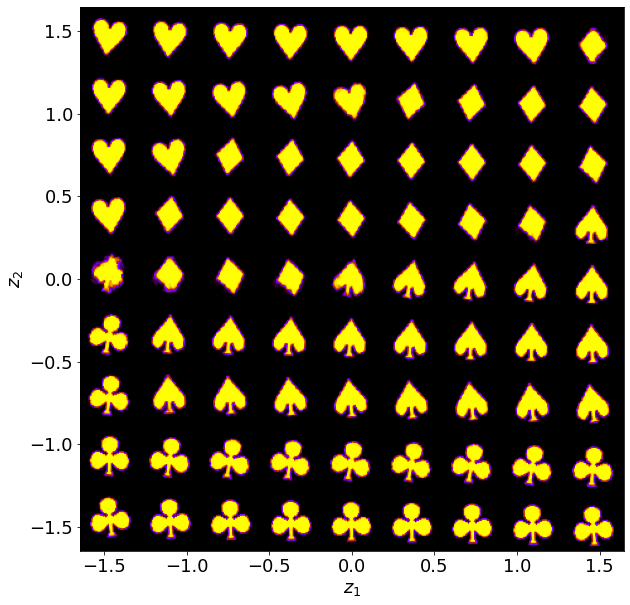

Encoded data


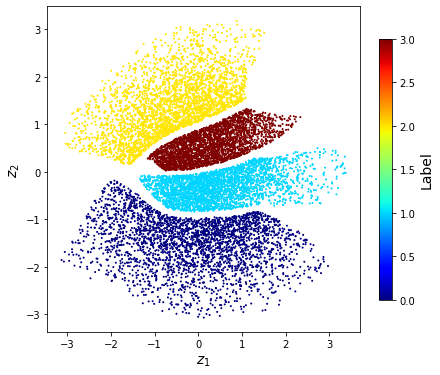

Latent manifold


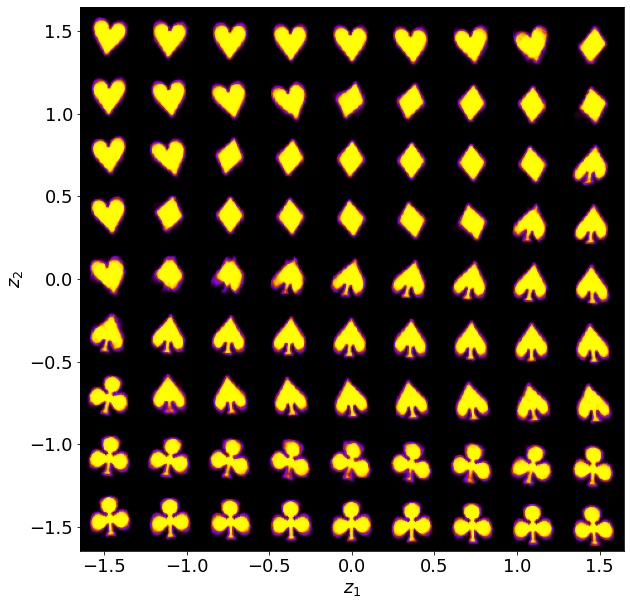

Encoded data


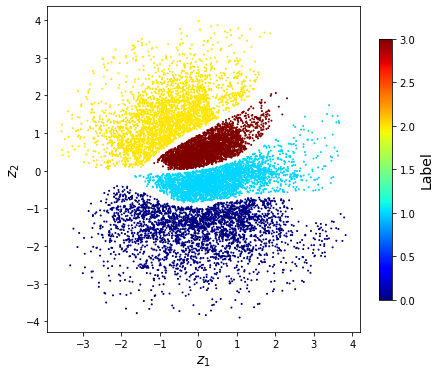

Latent manifold


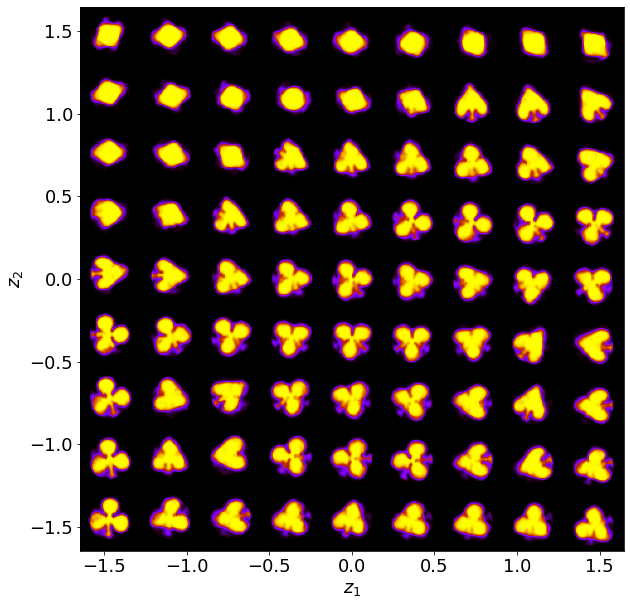

Encoded data


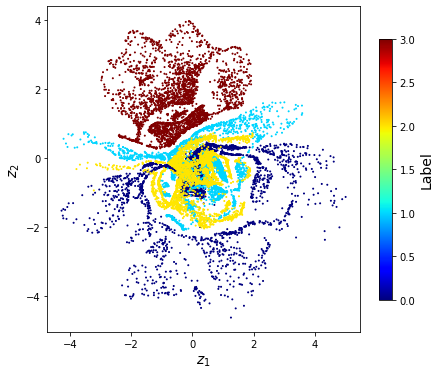

Latent manifold


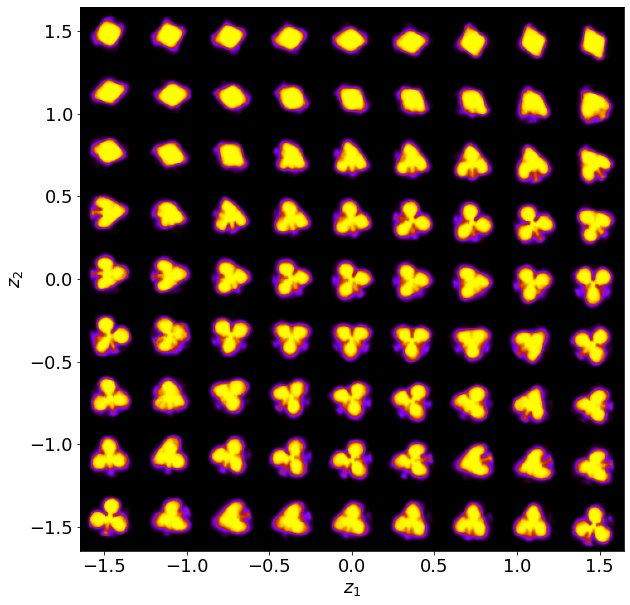

Encoded data


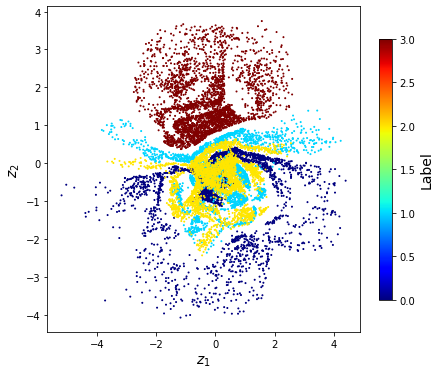

In [ ]:
aug_params = {1: [12, 0.1, 1], 2: [12, 0.1, 10], 3: [120, 0.1, 1], 4: [120, 0.1, 10]}

for p in aug_params.values():
    # Load model
    fname = "/content/drive/MyDrive/research/joint_rVAE/VAE_cards_degree{}shear{}.tar".format(p[0], p[2])
    model = aoi.load_model(fname)
    # Plot the learned manifold
    print("Latent manifold")
    model.manifold2d(d=9, origin="upper")
    # Encode the training data into the latent space and plot results
    cards_all, _ = transform_images(  # Since we used a fixed seed we can reproduce the same transformation
        card1, card2, card3, card4, angle=p[0], translation=p[1], shear=p[2])
    print("Encoded data")
    z_mean, z_sd = model.encode(cards_all)
    fig, ax = plt.subplots(1, 1, figsize =(7, 6))
    im = ax.scatter(z_mean[:,-1], z_mean[:,-2], c=labels_all, s=1, cmap='jet')
    ax.set_xlabel("$z_1$", fontsize=14)
    ax.set_ylabel("$z_2$", fontsize=14)
    cbar = fig.colorbar(im, ax=ax, shrink=.8)
    cbar.set_label("Label", fontsize=14)
    cbar.ax.tick_params(labelsize=10)
    plt.show()

## rVAE

Train rVAE model for four types of disorder:

Epoch: 1/200, Training loss: 818.4523
Epoch: 2/200, Training loss: 333.6352
Epoch: 3/200, Training loss: 253.7252
Epoch: 4/200, Training loss: 230.4216
Epoch: 5/200, Training loss: 208.9710
Epoch: 6/200, Training loss: 189.2115
Epoch: 7/200, Training loss: 171.3025
Epoch: 8/200, Training loss: 156.0283
Epoch: 9/200, Training loss: 140.9913
Epoch: 10/200, Training loss: 129.7144
Epoch: 11/200, Training loss: 120.8840
Epoch: 12/200, Training loss: 113.3982
Epoch: 13/200, Training loss: 109.3548
Epoch: 14/200, Training loss: 104.3995
Epoch: 15/200, Training loss: 101.9123
Epoch: 16/200, Training loss: 100.7927
Epoch: 17/200, Training loss: 98.6789
Epoch: 18/200, Training loss: 97.6777
Epoch: 19/200, Training loss: 96.0527
Epoch: 20/200, Training loss: 96.5162
Epoch: 21/200, Training loss: 94.8270
Epoch: 22/200, Training loss: 94.9119
Epoch: 23/200, Training loss: 95.0694
Epoch: 24/200, Training loss: 93.3383
Epoch: 25/200, Training loss: 93.2589
Epoch: 26/200, Training loss: 92.5477
Epoch

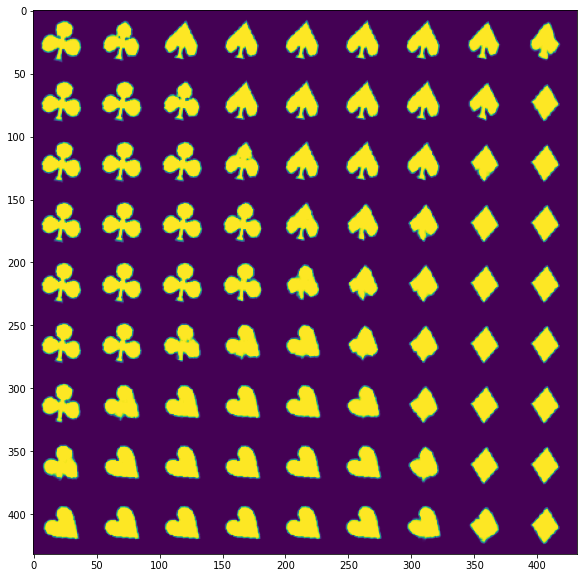

Epoch: 1/200, Training loss: 821.9606
Epoch: 2/200, Training loss: 337.4539
Epoch: 3/200, Training loss: 268.7621
Epoch: 4/200, Training loss: 248.5323
Epoch: 5/200, Training loss: 229.2611
Epoch: 6/200, Training loss: 209.3704
Epoch: 7/200, Training loss: 191.4481
Epoch: 8/200, Training loss: 175.9209
Epoch: 9/200, Training loss: 161.7059
Epoch: 10/200, Training loss: 148.8555
Epoch: 11/200, Training loss: 138.3317
Epoch: 12/200, Training loss: 128.3937
Epoch: 13/200, Training loss: 122.1193
Epoch: 14/200, Training loss: 116.9379
Epoch: 15/200, Training loss: 113.7166
Epoch: 16/200, Training loss: 110.7583
Epoch: 17/200, Training loss: 107.9882
Epoch: 18/200, Training loss: 105.8735
Epoch: 19/200, Training loss: 105.8553
Epoch: 20/200, Training loss: 102.9692
Epoch: 21/200, Training loss: 102.0167
Epoch: 22/200, Training loss: 101.8332
Epoch: 23/200, Training loss: 100.8065
Epoch: 24/200, Training loss: 100.4248
Epoch: 25/200, Training loss: 99.1254
Epoch: 26/200, Training loss: 98.71

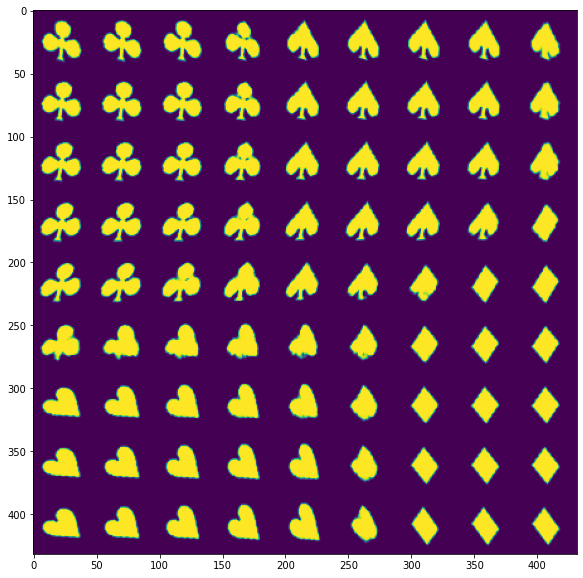

Epoch: 1/200, Training loss: 823.7886
Epoch: 2/200, Training loss: 348.7934
Epoch: 3/200, Training loss: 310.7202
Epoch: 4/200, Training loss: 297.3996
Epoch: 5/200, Training loss: 288.6107
Epoch: 6/200, Training loss: 280.0016
Epoch: 7/200, Training loss: 271.9479
Epoch: 8/200, Training loss: 260.2089
Epoch: 9/200, Training loss: 250.7826
Epoch: 10/200, Training loss: 238.7667
Epoch: 11/200, Training loss: 229.1166
Epoch: 12/200, Training loss: 220.1854
Epoch: 13/200, Training loss: 211.3482
Epoch: 14/200, Training loss: 201.2414
Epoch: 15/200, Training loss: 192.3963
Epoch: 16/200, Training loss: 185.4430
Epoch: 17/200, Training loss: 175.9619
Epoch: 18/200, Training loss: 170.2611
Epoch: 19/200, Training loss: 164.8652
Epoch: 20/200, Training loss: 158.1139
Epoch: 21/200, Training loss: 152.4049
Epoch: 22/200, Training loss: 147.2000
Epoch: 23/200, Training loss: 144.1117
Epoch: 24/200, Training loss: 139.0862
Epoch: 25/200, Training loss: 135.4805
Epoch: 26/200, Training loss: 132.

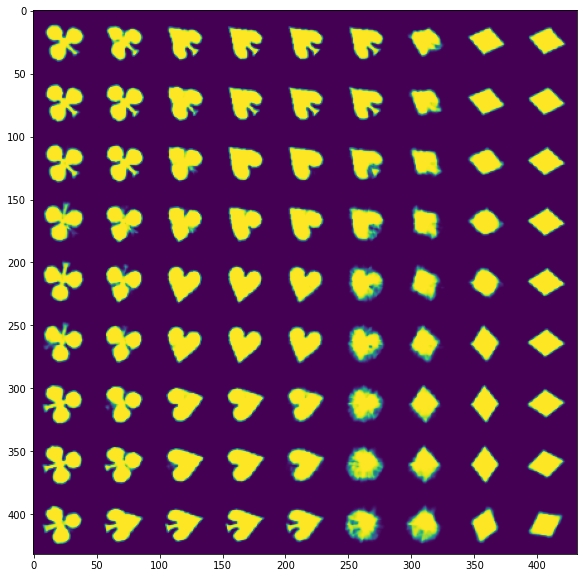

Epoch: 1/200, Training loss: 826.9095
Epoch: 2/200, Training loss: 362.0827
Epoch: 3/200, Training loss: 328.3370
Epoch: 4/200, Training loss: 316.6786
Epoch: 5/200, Training loss: 308.3882
Epoch: 6/200, Training loss: 298.6238
Epoch: 7/200, Training loss: 290.6250
Epoch: 8/200, Training loss: 281.6355
Epoch: 9/200, Training loss: 271.9180
Epoch: 10/200, Training loss: 261.2928
Epoch: 11/200, Training loss: 252.7303
Epoch: 12/200, Training loss: 243.4791
Epoch: 13/200, Training loss: 235.2767
Epoch: 14/200, Training loss: 228.1662
Epoch: 15/200, Training loss: 222.3112
Epoch: 16/200, Training loss: 214.7074
Epoch: 17/200, Training loss: 210.1503
Epoch: 18/200, Training loss: 203.0183
Epoch: 19/200, Training loss: 196.5376
Epoch: 20/200, Training loss: 192.0067
Epoch: 21/200, Training loss: 187.8536
Epoch: 22/200, Training loss: 182.4370
Epoch: 23/200, Training loss: 177.4784
Epoch: 24/200, Training loss: 173.7269
Epoch: 25/200, Training loss: 167.3995
Epoch: 26/200, Training loss: 162.

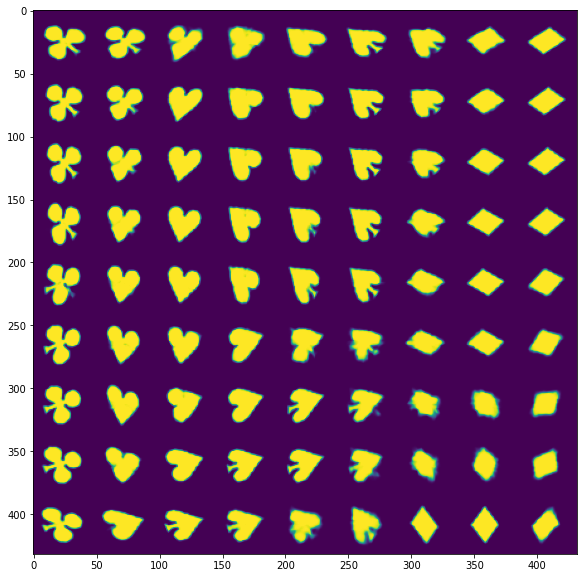

In [ ]:
input_dim = (48, 48)

aug_params = {1: [12, 0.1, 1], 2: [12, 0.1, 10], 3: [120, 0.1, 1], 4: [120, 0.1, 10]}

for p in aug_params.values():

    cards_all, _ = transform_images(
        card1, card2, card3, card4, angle=p[0], translation=p[1], shear=p[2])
    
    rvae = aoi.models.rVAE(input_dim, latent_dim=2,
                            numlayers_encoder=3, numhidden_encoder=512,
                            numlayers_decoder=3, numhidden_decoder=512,
                            skip=True)
    
    rvae.fit(cards_all, training_cycles=200, batch_size=100, loss="ce", translation_prior=0.1,
             filename="/content/drive/MyDrive/research/joint_rVAE/rVAE_cards_degree{}shear{}".format(p[0], p[2]))

    rvae.manifold2d(cmap="viridis", origin="upper")

Load the trained rVAE models and plot the learned manifolds and data encodings:

Latent manifold


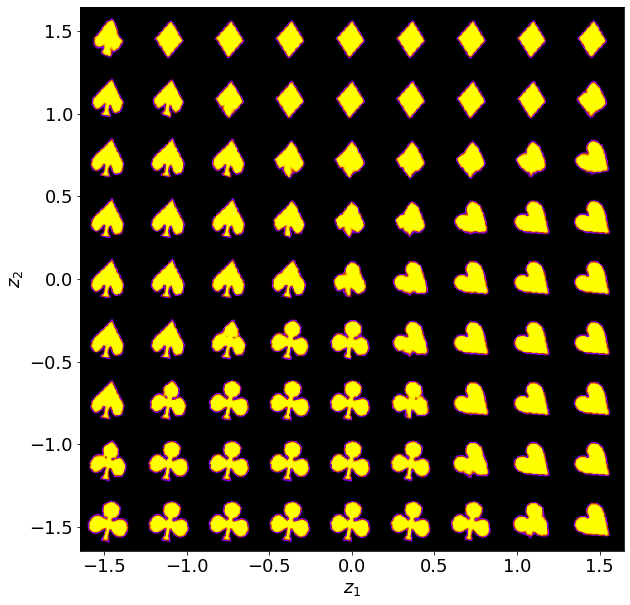

Encoded data


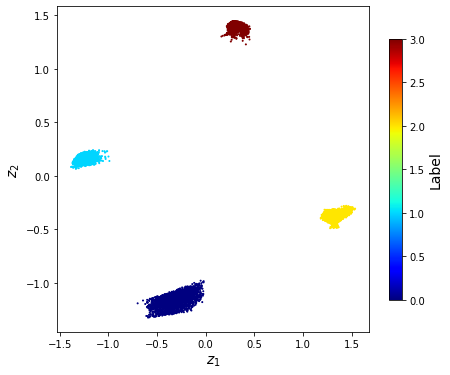

Latent manifold


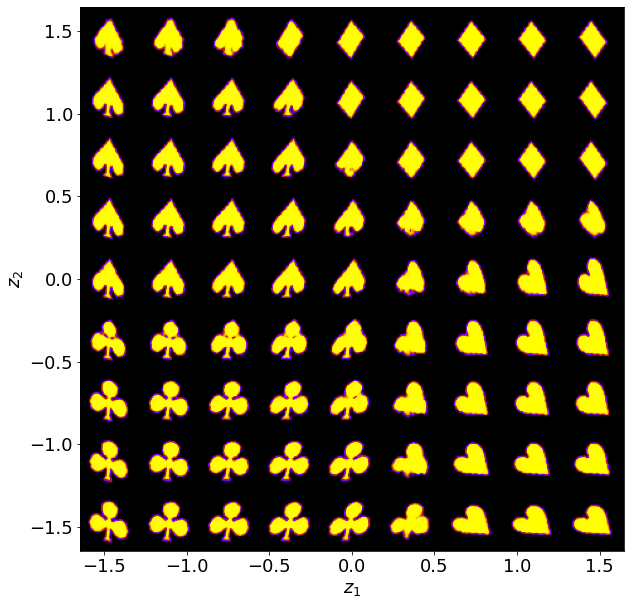

Encoded data


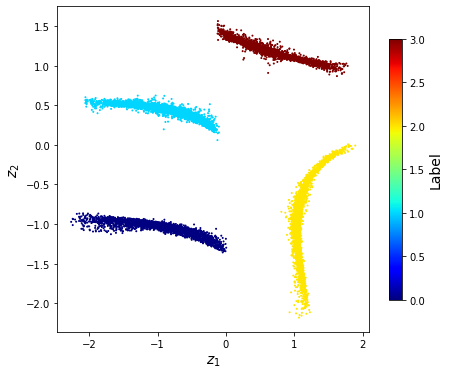

Latent manifold


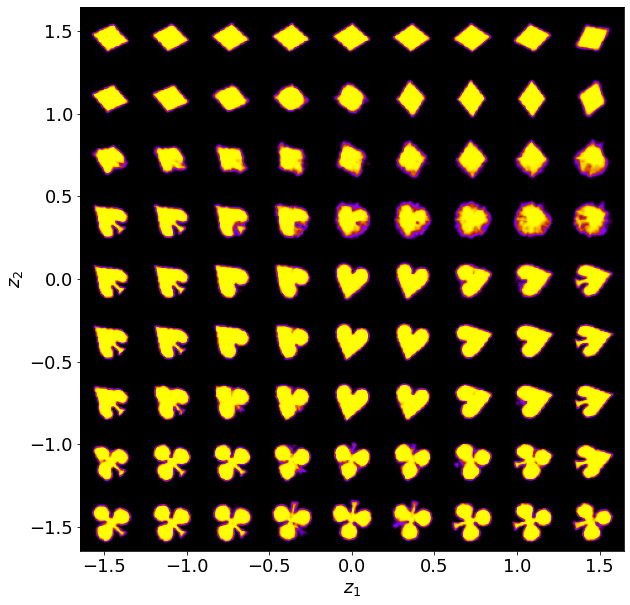

Encoded data


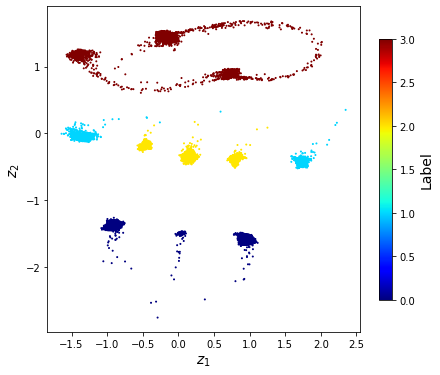

Latent manifold


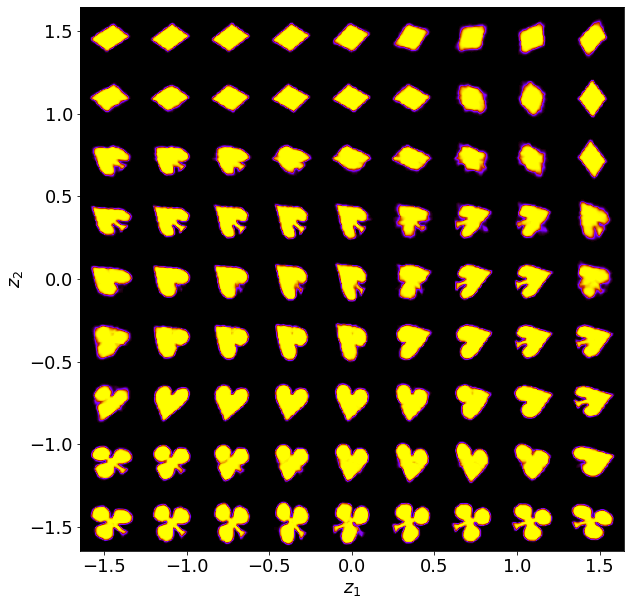

Encoded data


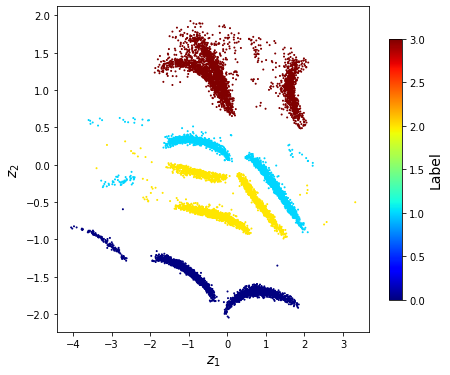

In [ ]:
aug_params = {1: [12, 0.1, 1], 2: [12, 0.1, 10], 3: [120, 0.1, 1], 4: [120, 0.1, 10]}

for p in aug_params.values():
    # Load model
    fname = "/content/drive/MyDrive/research/joint_rVAE/rVAE_cards_degree{}shear{}.tar".format(p[0], p[2])
    model = aoi.load_model(fname)
    # Plot the learned manifold
    print("Latent manifold")
    model.manifold2d(d=9, origin="upper")
    # Encode the training data into the latent space and plot results
    cards_all, _ = transform_images(  # Since we used a fixed seed we can reproduce the same transformation
        card1, card2, card3, card4, angle=p[0], translation=p[1], shear=p[2])
    print("Encoded data")
    z_mean, z_sd = model.encode(cards_all)
    fig, ax = plt.subplots(1, 1, figsize =(7, 6))
    im = ax.scatter(z_mean[:,-1], z_mean[:,-2], c=labels_all, s=1, cmap='jet')
    ax.set_xlabel("$z_1$", fontsize=14)
    ax.set_ylabel("$z_2$", fontsize=14)
    cbar = fig.colorbar(im, ax=ax, shrink=.8)
    cbar.set_label("Label", fontsize=14)
    cbar.ax.tick_params(labelsize=10)
    plt.show()

##jVAE

Train jVAE model for two types of disorder (small and large rotation angle)

In [ ]:
input_dim = (48, 48)

aug_params = {1: [12, 0.1, 10], 2: [120, 0.1, 10]}

for p in aug_params.values():

    cards_all, _ = transform_images(
        card1, card2, card3, card4, angle=p[0], translation=p[1], shear=p[2])
    
    jvae = aoi.models.jVAE(input_dim, latent_dim=2, discrete_dim=[4],
                           numlayers_encoder=3, numhidden_encoder=1024,
                           numlayers_decoder=3, numhidden_decoder=1024,
                           skip=True)
    
    jvae.fit(cards_all, training_cycles=200, batch_size=100, loss="ce", translation_prior=0.1,
             filename="/content/drive/MyDrive/research/joint_rVAE/jVAE_cards_degree{}shear{}".format(p[0], p[2]))

Load the trained jVAE models and plot the learned manifolds and data encodings:

Latent manifold traversals


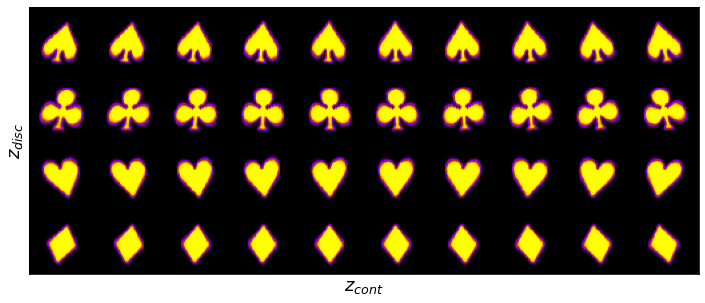

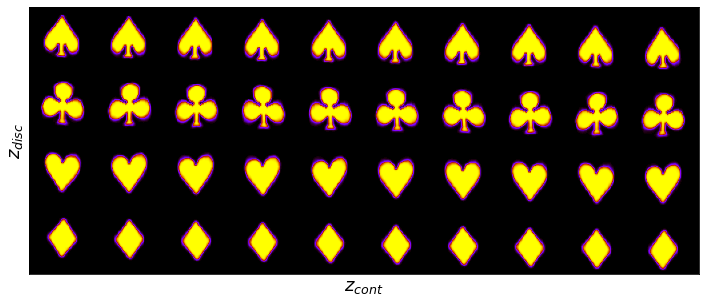

Latent manifolds for each class


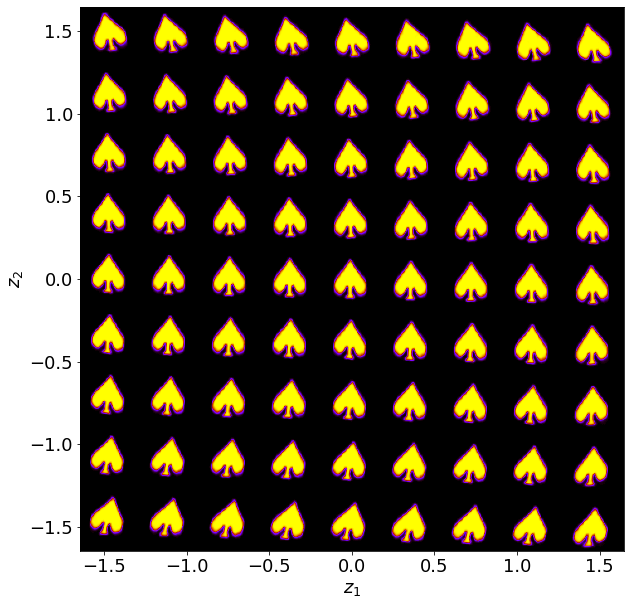

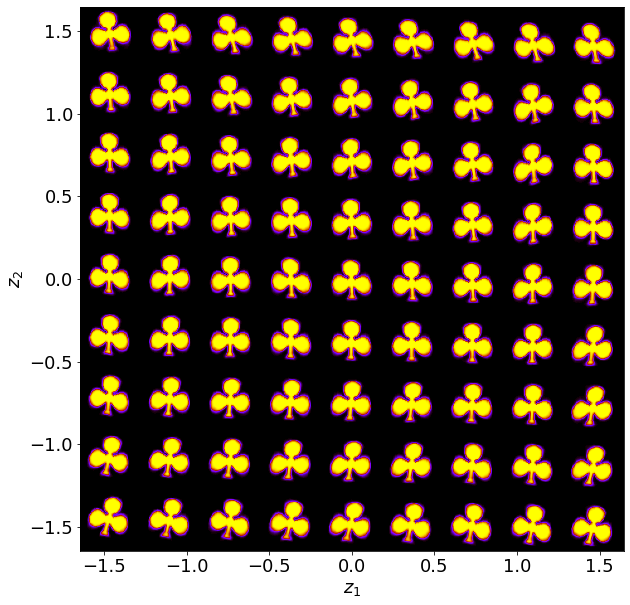

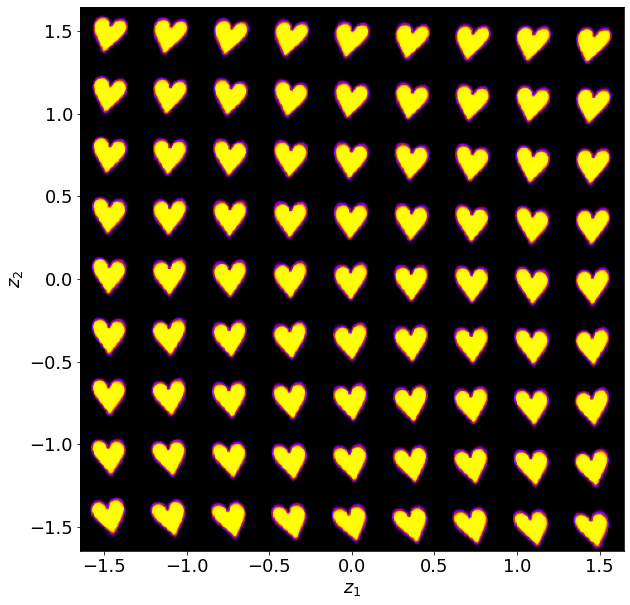

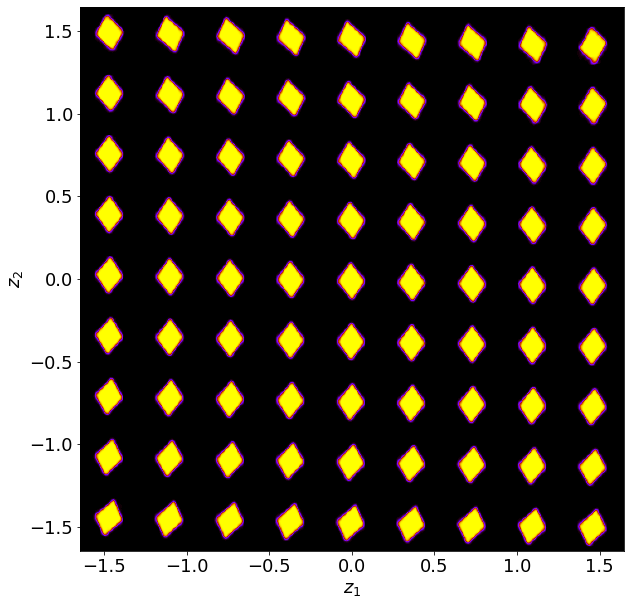

Encoded data


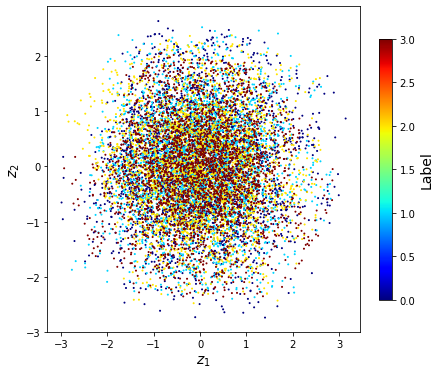

Latent manifold traversals


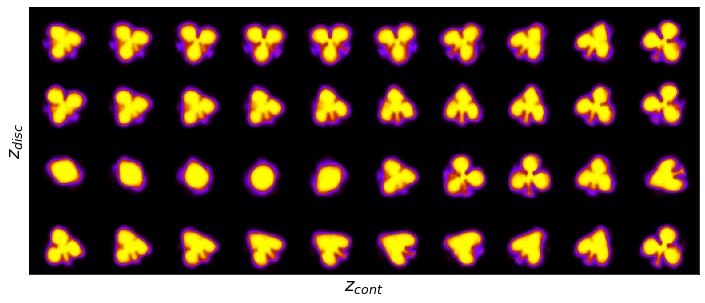

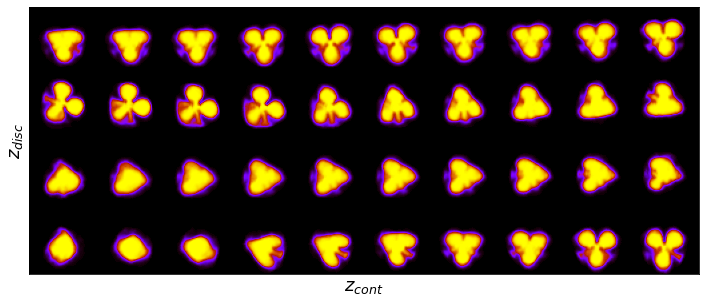

Latent manifolds for each class


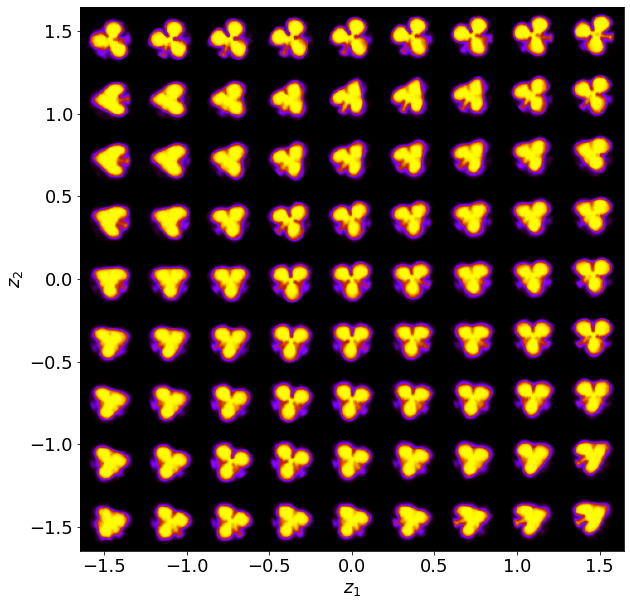

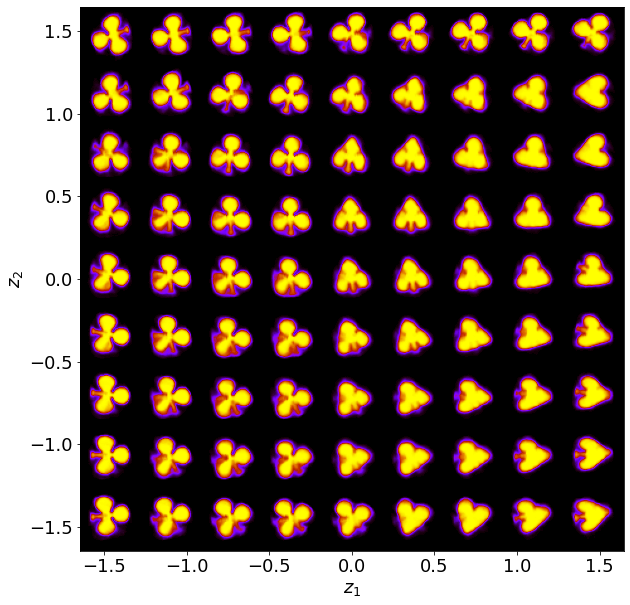

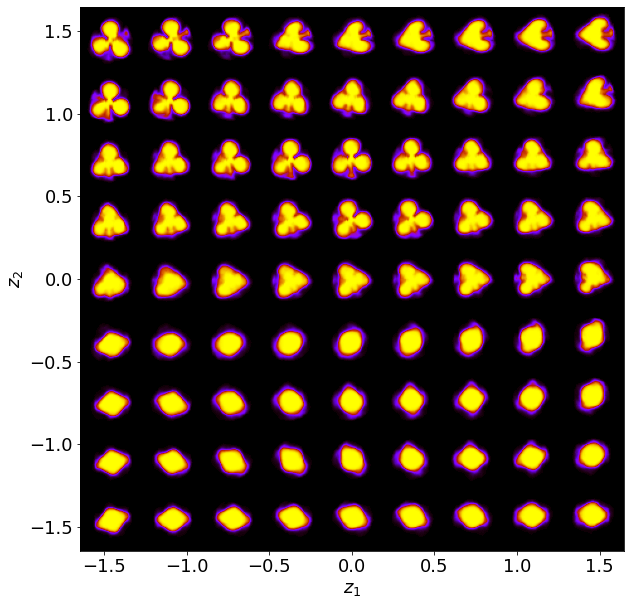

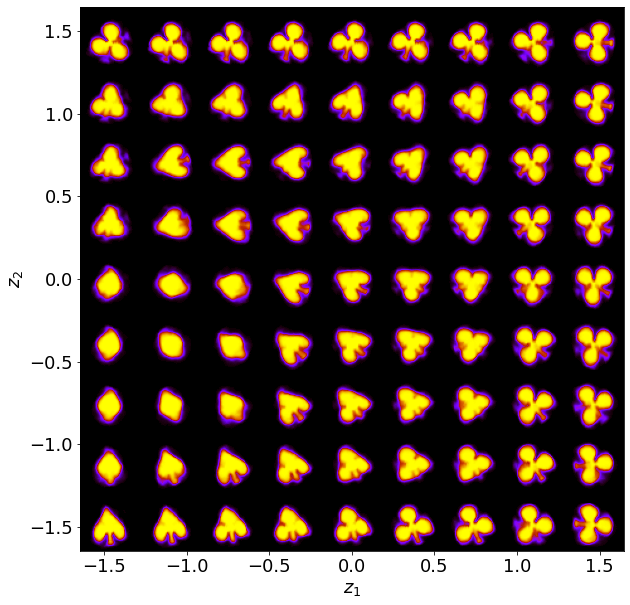

Encoded data


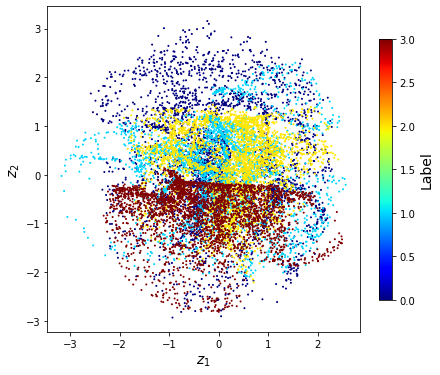

In [ ]:
aug_params = {1: [12, 0.1, 10], 2: [120, 0.1, 10]}

for p in aug_params.values():
    # Load model
    fname = "/content/drive/MyDrive/research/joint_rVAE/jVAE_cards_degree{}shear{}.tar".format(p[0], p[2])
    model = aoi.load_model(fname)
    # Plot the learned manifolds
    print("Latent manifold traversals")
    for i in range(2):
        model.manifold_traversal(i, origin="upper");
    print("Latent manifolds for each class")
    for i in range(4):
        model.manifold2d(d=9, disc_idx=i, origin="upper")
    # Encode the training data into the latent space and plot results
    cards_all, _ = transform_images(  # Since we used a fixed seed we can reproduce the same transformation
        card1, card2, card3, card4, angle=p[0], translation=p[1], shear=p[2])
    print("Encoded data")
    z_mean, z_sd, _ = model.encode(cards_all)
    fig, ax = plt.subplots(1, 1, figsize =(7, 6))
    im = ax.scatter(z_mean[:,-1], z_mean[:,-2], c=labels_all, s=1, cmap='jet')
    ax.set_xlabel("$z_1$", fontsize=14)
    ax.set_ylabel("$z_2$", fontsize=14)
    cbar = fig.colorbar(im, ax=ax, shrink=.8)
    cbar.set_label("Label", fontsize=14)
    cbar.ax.tick_params(labelsize=10)
    plt.show()

##jrVAE

Train jrVAE model for two types of disorder (small and large rotation angle)

In [ ]:
input_dim = (48, 48)

aug_params = {1: [12, 0.1, 10], 2: [120, 0.1, 10]}

for p in aug_params.values():

    cards_all, _ = transform_images(
        card1, card2, card3, card4, angle=p[0], translation=p[1], shear=p[2])
    
    jrvae = aoi.models.jrVAE(input_dim, latent_dim=2, discrete_dim=[4],
                             numlayers_encoder=3, numhidden_encoder=1024,
                             numlayers_decoder=3, numhidden_decoder=1024,
                             skip=True, seed=12)
    
    jrvae.fit(cards_all, training_cycles=200, batch_size=100, loss="ce", translation_prior=0.1,
             filename="/content/drive/MyDrive/research/joint_rVAE/jrVAE_cards_degree{}shear{}".format(p[0], p[2]))

Load the trained jVAE models and plot the learned manifolds and data encodings:

Latent manifold traversals


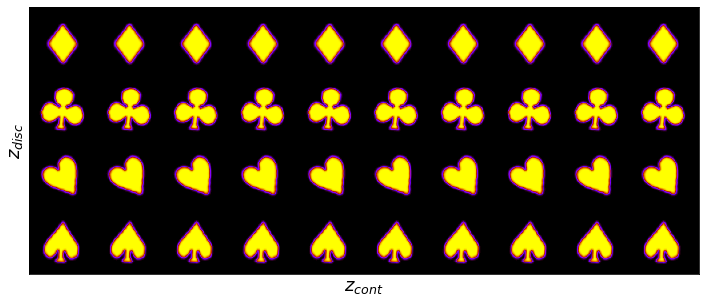

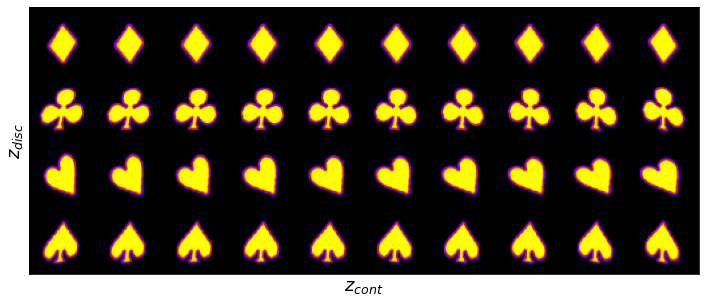

Latent manifolds for each class


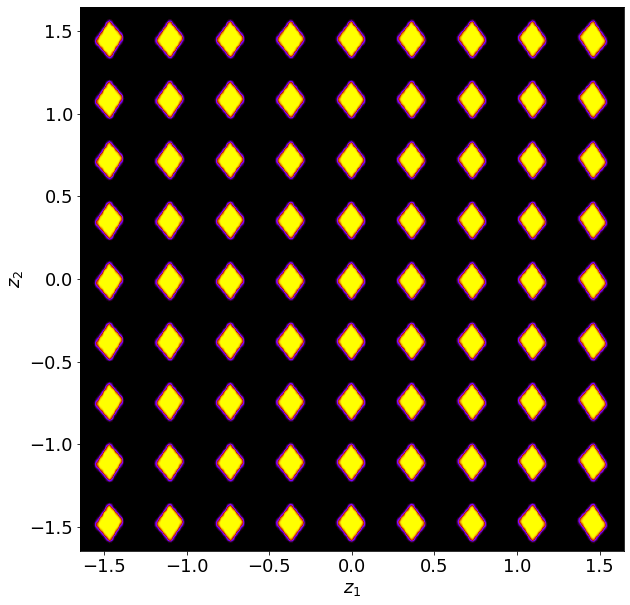

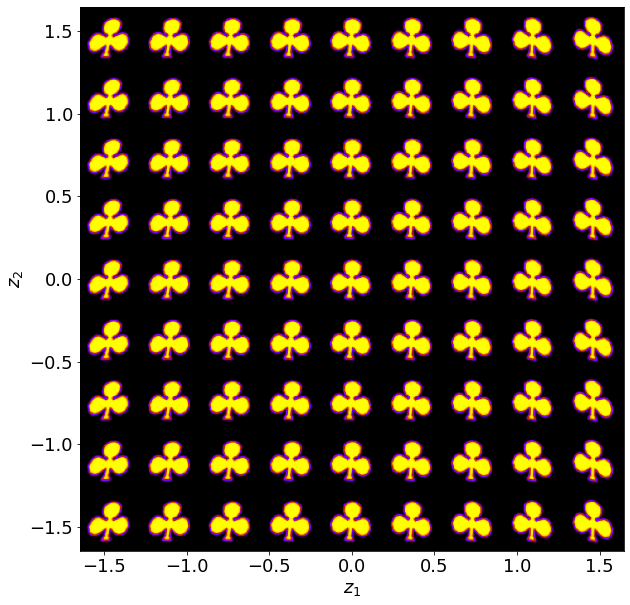

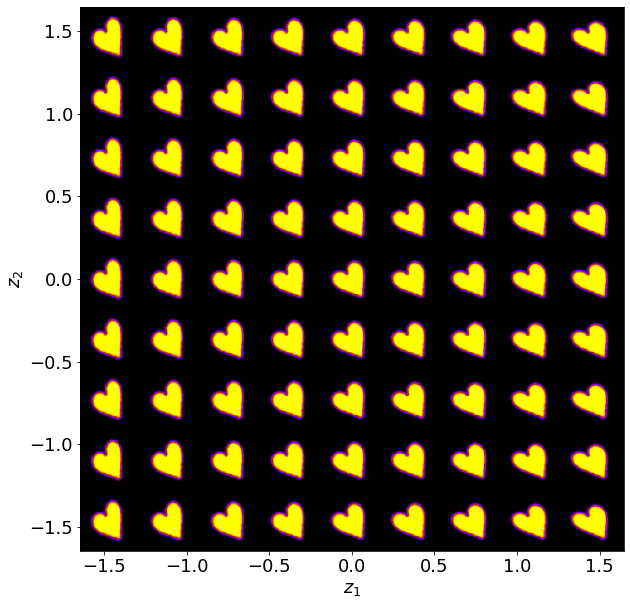

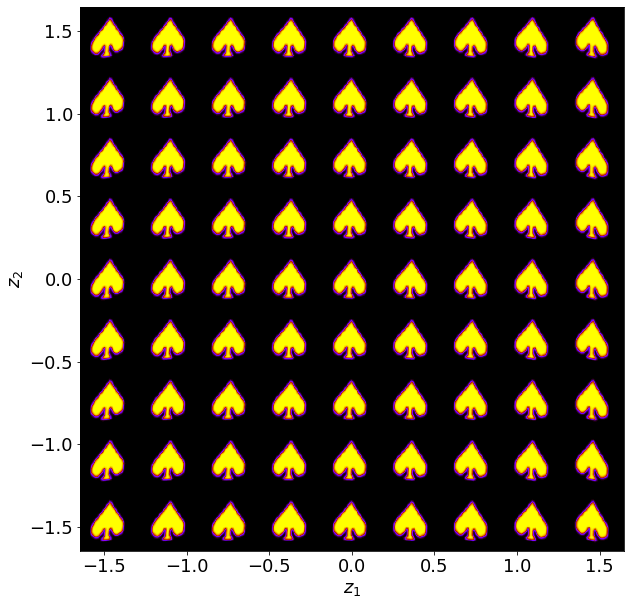

Encoded data


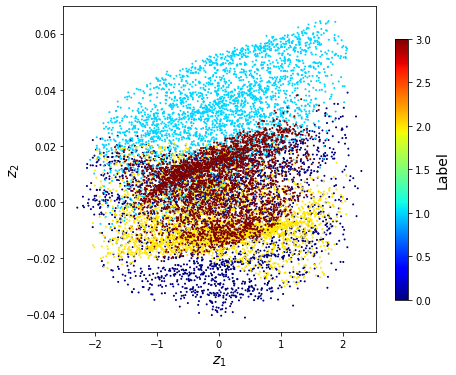

Latent manifold traversals


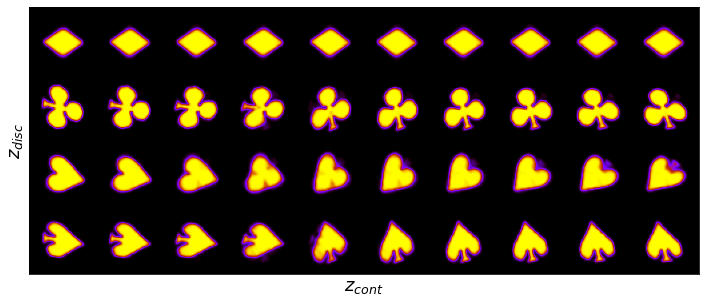

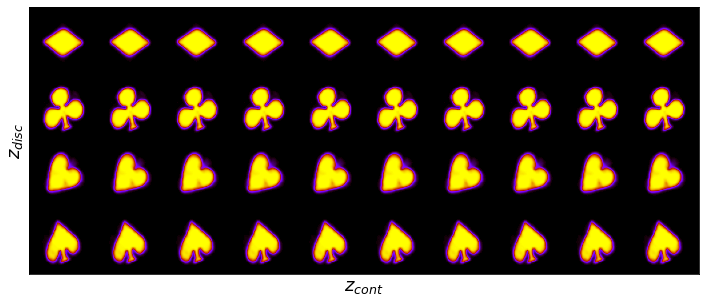

Latent manifolds for each class


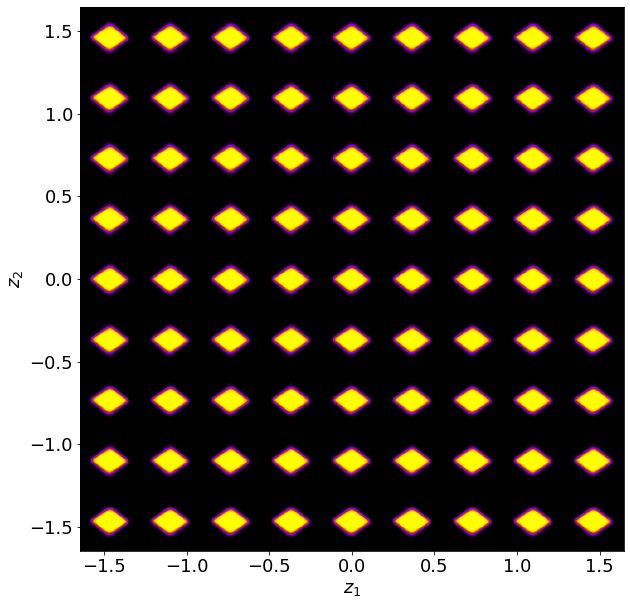

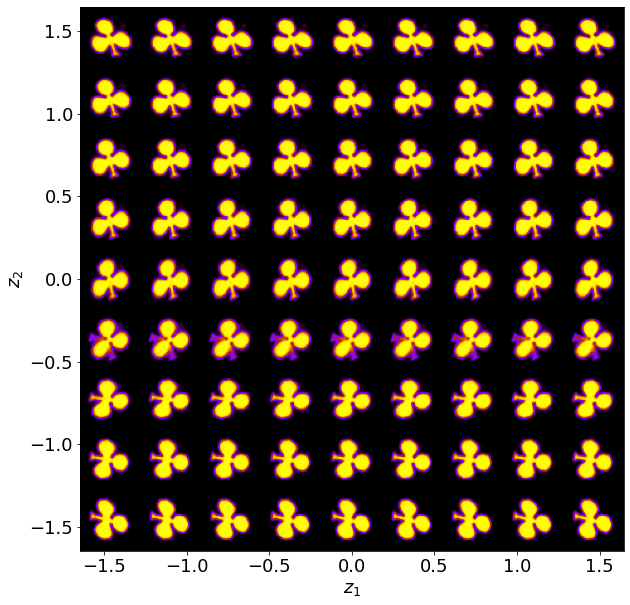

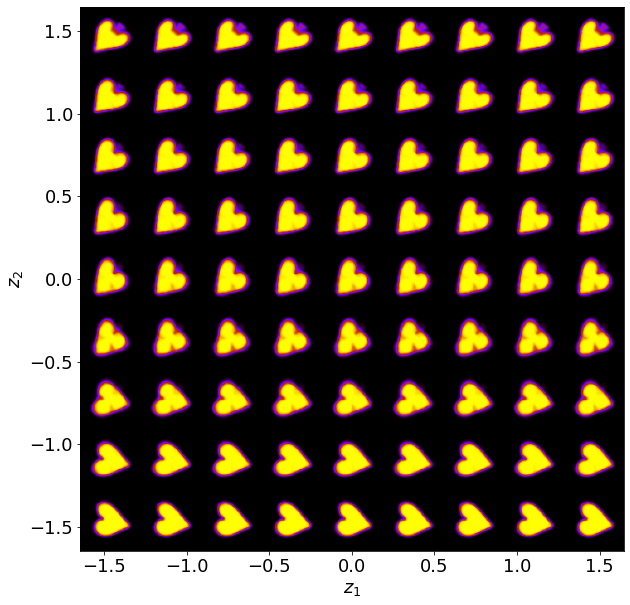

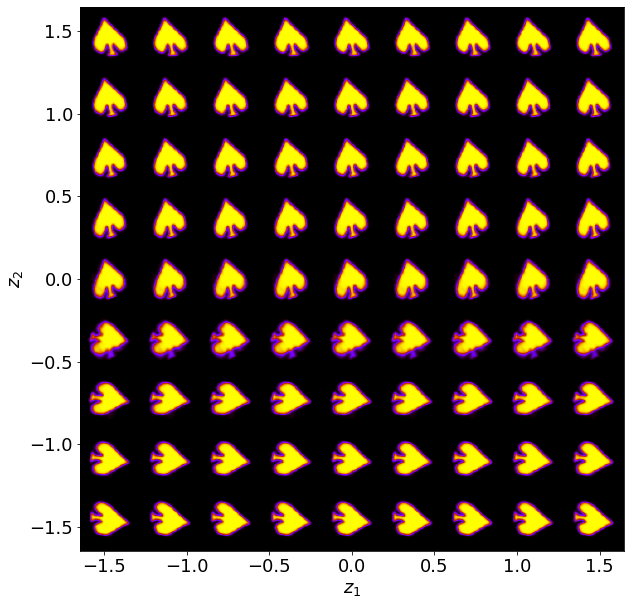

Encoded data


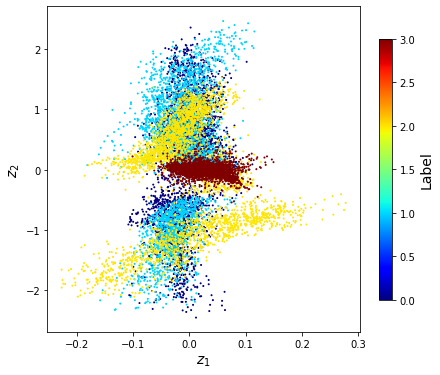

In [ ]:
aug_params = {1: [12, 0.1, 10], 2: [120, 0.1, 10]}

for p in aug_params.values():
    # Load model
    fname = "/content/drive/MyDrive/research/joint_rVAE/jrVAE_cards_degree{}shear{}.tar".format(p[0], p[2])
    model = aoi.load_model(fname)
    # Plot the learned manifolds
    print("Latent manifold traversals")
    for i in range(2):
        model.manifold_traversal(i, origin="upper");
    print("Latent manifolds for each class")
    for i in range(4):
        model.manifold2d(d=9, disc_idx=i, origin="upper")
    # Encode the training data into the latent space and plot results
    cards_all, _ = transform_images(  # Since we used a fixed seed we can reproduce the same transformation
        card1, card2, card3, card4, angle=p[0], translation=p[1], shear=p[2])
    print("Encoded data")
    z_mean, z_sd, _ = model.encode(cards_all)
    fig, ax = plt.subplots(1, 1, figsize =(7, 6))
    im = ax.scatter(z_mean[:,-1], z_mean[:,-2], c=labels_all, s=1, cmap='jet')
    ax.set_xlabel("$z_1$", fontsize=14)
    ax.set_ylabel("$z_2$", fontsize=14)
    cbar = fig.colorbar(im, ax=ax, shrink=.8)
    cbar.set_label("Label", fontsize=14)
    cbar.ax.tick_params(labelsize=10)
    plt.show()